In [98]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

# Домашнее задание №5

[Задача 1](#Pr1) 
    
[Задача 2](#Pr2) 

**Задача 1.** Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем. <a class="anchor" id="Pr1"></a>

In [99]:
# сгенерируем данные, представляющие собой 1000 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

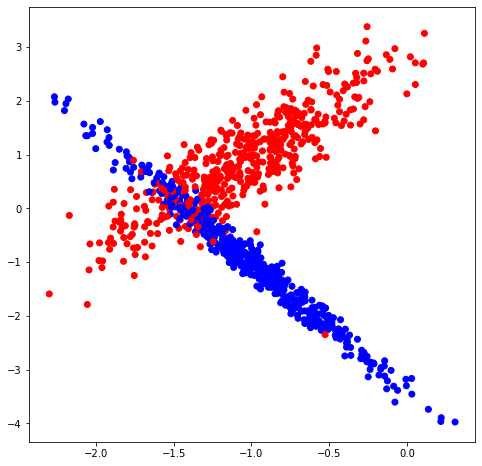

In [100]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Генерация бутстрап-выборок

In [101]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

Генерация подмножеств признаков (для нахождения разбиения в узле)

In [102]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Реализация алгоритма построения дерева решений

In [103]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [104]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [105]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [106]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [107]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [108]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [109]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Функция формирования случайного леса

In [110]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

Функции получения реззультата работы алгоритма

In [111]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [112]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [113]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Пример работы алгоритма

In [114]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [115]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Обучим случайный лес из 1, 3 и 10 деревьев

In [116]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [117]:
# функция для обучения леса и вывода результата
def learn_forest(train_data, train_labels, n_trees):    
    
    my_forest = random_forest(train_data, train_labels, n_trees)

    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, train_data)

    # Получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    
    # Визуализируем дерево на графике
    plt.figure(figsize = (16, 7))
    plt.suptitle(f'Случайный лес из {n_trees} деревьев')

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

<ipython-input-117-0e68a87f8b2c>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-117-0e68a87f8b2c>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


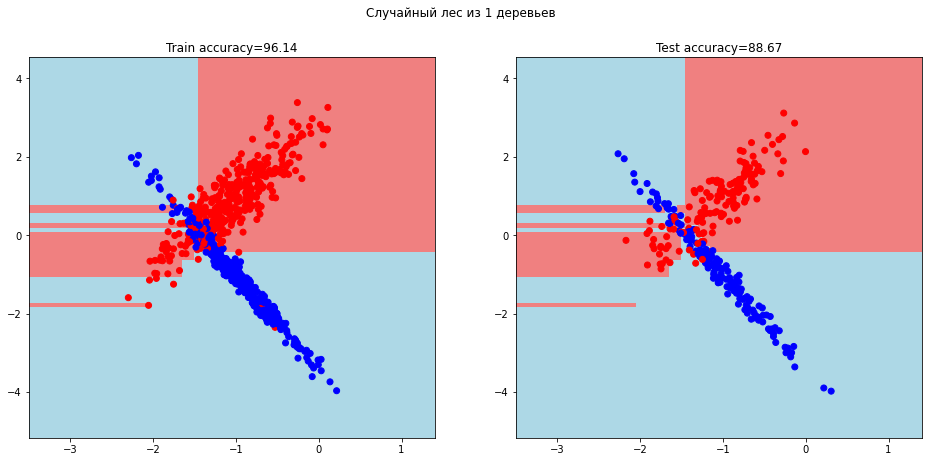

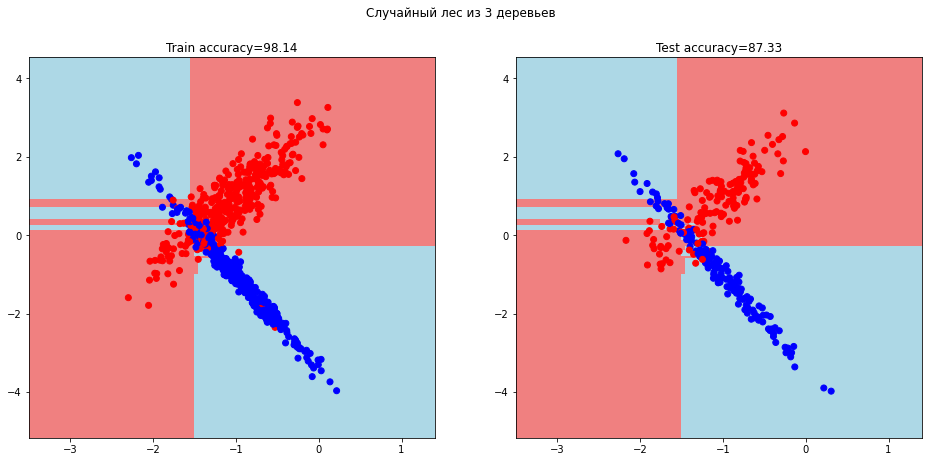

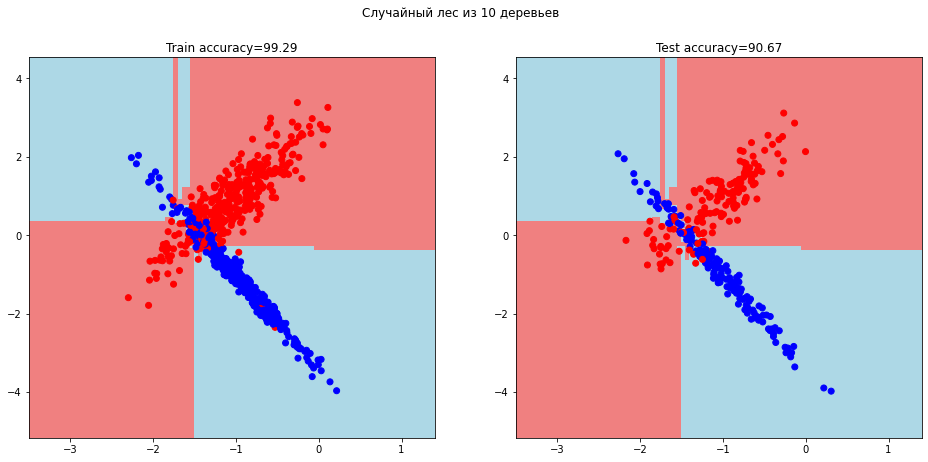

In [118]:
n_trees = [1, 3, 10]

for i in n_trees:
    learn_forest(train_data, train_labels, i)

Вывод: Разделяющая гиперплоскость имеет самую сложную форму при количестве деревьев = 1, а самую простую -- при количестве деревьев = 10. При этом, случайный лес переобучен. Сильнее всего переобучение при количестве деревьев = 3, меньше всего -- при количестве деревьев = 1. 

Таким образом, чем меньше количество деревьев, тем сложнее гиперплоскость, и тем меньше переобучение.

Обучим случайный лес из 50, 100 и 200 деревьев

<ipython-input-117-0e68a87f8b2c>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-117-0e68a87f8b2c>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


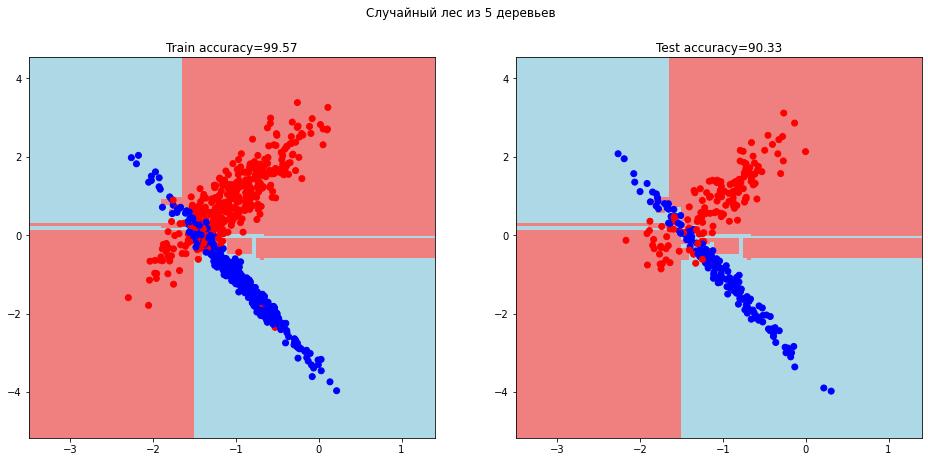

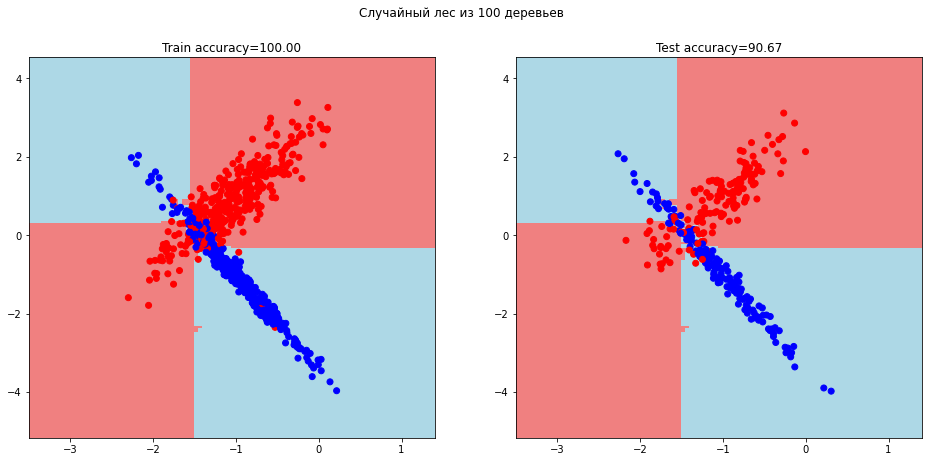

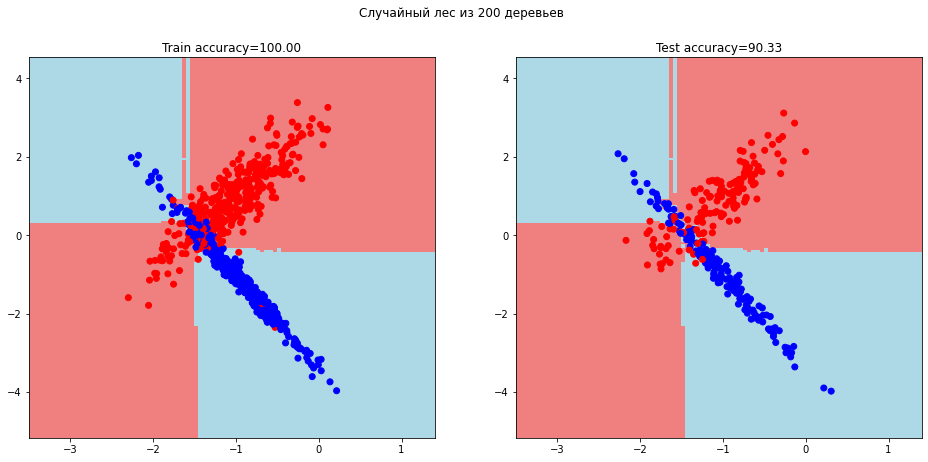

In [119]:
n_trees = [5, 100, 200]

for i in n_trees:
    learn_forest(train_data, train_labels, i)

Вывод: Разделяющая гиперплоскость имеет самую сложную форму при количестве деревьев = 5, а самую простую -- при количестве деревьев = 100. При этом, случайный лес переобучен. Сильнее всего переобучение при количестве деревьев = 200, меньше всего -- при количестве деревьев = 5. 

Таким образом, чем меньше количество деревьев, тем сложнее гиперплоскость, и тем меньше переобучение.

**Вывод:** чем меньше количество деревьев, тем сложнее гиперплоскость, и тем меньше переобучение.

**Задача 2*.** Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag. <a class="anchor" id="Pr2"></a>

In [120]:
#вычислим данные, которые не вошли в бутстрап-выборки для каждого дерева из случайного леса
random.seed(42)

def get_not_in_bootstrap(data, labels, bootstrap):
    not_in_bootstrap = []
    for i in range(len(bootstrap)):
        use_data = np.unique(bootstrap[i][0], axis = 0) #уникальные используемые данные
        use_index = []
        for i in range(use_data.shape[0]):
            for j in range(data.shape[0]):
                if (use_data[i] == data[j]).all():
                    use_index.append(j)
        
        # Определяем объекты, которые не используются в бутстрап       
        not_use_data = np.delete(data, use_index, axis = 0)
        not_use_labels = np.delete(labels, use_index, axis = 0)

        #составляем список кортежей из неиспользованных данных
        not_in_bootstrap.append((not_use_data, not_use_labels))
    return not_in_bootstrap

In [121]:
# функция формирования случайного леса 
# возвращаются два леса: один построен из n деревьев на бутстрап выборках, 
# другой -- на объектах, не вошедших в бутстрап-выборки

def forest_OOB(data, labels, n_trees):
    forest = [[],[]] #список деревьев на бутстрап-выборках и список деревьев на объектах не из бутстрап-выборках
    bootstrap = get_bootstrap(data, labels, n_trees)
    not_in_bootstrap = get_not_in_bootstrap(data, labels, bootstrap)
    
    for b_data, b_labels in bootstrap:
        forest[0].append(build_tree(b_data, b_labels)) #cтроим деревья бутстрап-выборках
    
    for not_b_data, not_b_labels in not_in_bootstrap:
        forest[1].append(build_tree(not_b_data, not_b_labels)) #строим деревья на объектах, не попавших в бутстрап выборку каждого дерева      
    return forest

In [122]:
# предсказание голосованием деревьев на бутстрап выборках

def tree_vote(forest, data):
    
    random_forest = forest[0]
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in random_forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [123]:
# предсказание голосованием деревьев на бутстрап выборках

def tree_vote_OOB(forest, data):
    
    random_forest = forest[1]
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in random_forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_OOB_predictions = []
    for obj in predictions_per_object:
        voted_OOB_predictions.append(max(set(obj), key=obj.count))
        
    return voted_OOB_predictions

Обучим случайный лес из n-trees деревьев и оценим accuracy леса на бутстрап-выборках и ассuracy леса на объектах не вошедших в бутстрап-выборки каждого дерева.

In [124]:
for n_trees in [1, 3, 10]:
    my_forest_OOB = forest_OOB(classification_data, classification_labels, n_trees)
    
    # Получим ответы для бутстрап выборках
    bootstrap_answers = tree_vote(my_forest_OOB, classification_data)
    
    # Точность на бутстрап выборках
    b_accuracy = accuracy_metric(classification_labels, bootstrap_answers)
        
    # Получим ответы случайного леса из n деревьев на данных, которые не вошли в бутстрап-выборки каждого дерева
    not_in_bootstrap_answers = tree_vote_OOB(my_forest_OOB, classification_data)
    
    # Точность на данных, которые не вошли в бутстрап выборки
    not_b_accuracy = accuracy_metric(classification_labels, not_in_bootstrap_answers)
    
    print(f'Случайный лес из {n_trees} деревьев:')
    print(f'Accuracy на бутстрап-выборках: {b_accuracy:.3f}')
    print(f'Accuracy на данных, не попавших в бутстрап выборки (OOB): {not_b_accuracy:.3}')

Случайный лес из 1 деревьев:
Accuracy на бутстрап-выборках: 95.900
Accuracy на данных, не попавших в бутстрап выборки (OOB): 91.3
Случайный лес из 3 деревьев:
Accuracy на бутстрап-выборках: 98.100
Accuracy на данных, не попавших в бутстрап выборки (OOB): 94.7
Случайный лес из 10 деревьев:
Accuracy на бутстрап-выборках: 99.800
Accuracy на данных, не попавших в бутстрап выборки (OOB): 97.4


**Вывод:** с использованием out-of-bag модель стабильна.